# Step 3: Build PSF Model with SVI (mask-aware)

这个 notebook 使用 `Herculens_Tian_JWST.ipynb` 同款的 SVI 思路，
对 29 个 `psf_data/*SCIERR.fits` 联合建模。

建模结构：
- `PSF_model_ss = STPSF_base_ss + correction_ss`
- `correction_ss` 来自 `matern_power_spectrum + white-noise Fourier modes`
- 在 supersampled 网格建模后，`resize` 到 detector 101x101
- 每个观测星点自由度：`x_pos, y_pos, log10_flux, background`


In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import warnings
warnings.simplefilter("ignore")

import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
import numpyro.infer.autoguide as autoguide
import optax

import matplotlib.pyplot as plt
import arviz as az
from astropy.io import fits

jax.config.update("jax_enable_x64", True)
numpyro.enable_x64()

from power_spectrum_prior import P_Matern, pack_fft_values, K_grid
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.PointSourceModel.point_source_model import PointSourceModel


def split_scheduler(
    max_iterations,
    init_value=0.1,
    decay_rates=(0.99, 0.99),
    transition_steps=(50, 10),
    boundary=0.5,
):
    boundary = int(max_iterations * boundary)

    scheduler1 = optax.exponential_decay(
        init_value=init_value,
        decay_rate=decay_rates[0],
        transition_steps=transition_steps[0],
    )

    scheduler2 = optax.exponential_decay(
        init_value=scheduler1(boundary),
        decay_rate=decay_rates[1],
        transition_steps=transition_steps[1],
    )

    return optax.join_schedules([scheduler1, scheduler2], boundaries=[boundary])


class SVI_vec(numpyro.infer.SVI):
    def run(
        self,
        rng_key,
        num_chains,
        num_steps,
        *args,
        stable_update=False,
        forward_mode_differentiation=False,
        init_states=None,
        init_params=None,
        **kwargs,
    ):
        def body_fn(svi_state, _):
            if stable_update:
                svi_state, loss = self.stable_update(
                    svi_state,
                    *args,
                    forward_mode_differentiation=forward_mode_differentiation,
                    **kwargs,
                )
            else:
                svi_state, loss = self.update(
                    svi_state,
                    *args,
                    forward_mode_differentiation=forward_mode_differentiation,
                    **kwargs,
                )
            return svi_state, loss

        if init_states is None:
            rng_keys = jax.random.split(rng_key, num_chains)

            def init_one(k):
                return self.init(k, *args, init_params=init_params, **kwargs)

            svi_states = jax.vmap(init_one)(rng_keys)
        else:
            svi_states = init_states

        def run_one_chain(state):
            final_state, losses = jax.lax.scan(body_fn, state, jnp.arange(num_steps))
            return final_state, losses

        final_states, losses = jax.vmap(run_one_chain)(svi_states)
        return numpyro.infer.svi.SVIRunResult(self.get_params(final_states), final_states, losses)


def get_pixel_grid(data, pix_scale, ss=1):
    ny, nx = data.shape
    ny *= ss
    nx *= ss
    pix_scale /= ss
    half_size_x = nx * pix_scale / 2
    half_size_y = ny * pix_scale / 2
    ra_at_xy_0 = -half_size_x + pix_scale / 2
    dec_at_xy_0 = -half_size_y + pix_scale / 2
    transform_pix2angle = pix_scale * np.eye(2)
    kwargs_pixel = {
        'nx': nx,
        'ny': ny,
        'ra_at_xy_0': ra_at_xy_0,
        'dec_at_xy_0': dec_at_xy_0,
        'transform_pix2angle': transform_pix2angle,
    }
    pixel_grid = PixelGrid(**kwargs_pixel)
    xgrid, ygrid = pixel_grid.pixel_coordinates
    x_axis = xgrid[0]
    y_axis = ygrid[:, 0]
    extent = pixel_grid.extent
    return pixel_grid, xgrid, ygrid, x_axis, y_axis, extent, nx, ny


def matern_power_spectrum(
    plate_name,
    param_name,
    k,
    k_zero=None,
    n_high=100,
    n_value=None,
    positive=True,
):
    with numpyro.plate(f'{plate_name} power spectrum params - [1]', 1):
        if n_value is None:
            n = numpyro.sample(f'n_{param_name}', dist.LogUniform(0.3, n_high))
        else:
            n = numpyro.deterministic(f'n_{param_name}', jnp.atleast_1d(n_value))
        sigma = numpyro.sample(f'sigma_{param_name}', dist.LogUniform(1e-5, 10))
        rho = numpyro.sample(f'rho_{param_name}', dist.LogNormal(2.1, 1.1))

    P = P_Matern(k, n[0], sigma[0], rho[0], k_zero=k_zero)
    scale = jnp.sqrt(P)

    ny, nx = scale.shape
    with numpyro.plate(f'{plate_name} fft y - [{ny}]', ny):
        with numpyro.plate(f'{plate_name} fft x - [{nx}]', nx):
            pixels_wn = numpyro.sample(f'pixels_wn_{param_name}', dist.Normal(0, 1))

    gp = jnp.fft.irfft2(pack_fft_values(pixels_wn * scale), s=scale.shape, norm='ortho')
    if positive:
        gp = jax.nn.softplus(100 * gp) / 100.0
    pixels = numpyro.deterministic(f'pixels_{param_name}', gp)

    return {'pixels': pixels}


print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0)]


In [2]:
# -----------------------------
# Config
# -----------------------------
PIX_SCALE = 0.05
DATA_DIR = "../../Data/RXJ1131"
PSF_DATA_DIR = "./psf_data"
BASE_PSF_PATH = os.path.join(PSF_DATA_DIR, "C08_x3281_y684_SCIERR.fits")
BASE_PSF_EXT = "SCI"   # use SCI extension from selected C8 cutout
OUTPUT_DIR = PSF_DATA_DIR

# explicit candidate list from Step 2 selection
SELECTED_CANDS = [4, 6, 7, 8, 15, 16, 20, 21]

SEED = 123

# smoke test switch
SMOKE_TEST = True
SMOKE_MAX_STARS = 8
MAX_ITERATIONS = 120 if SMOKE_TEST else 8000
NUM_CHAINS = 1 if SMOKE_TEST else 4
NUM_POST_SAMPLES = 40 if SMOKE_TEST else 300
TRANSITION_STEPS = [40, 10] if SMOKE_TEST else [200, 20]
OUTPUT_SUFFIX = "_smoke" if SMOKE_TEST else ""

SS_FACTOR = 2

XPOS_PRIOR_SIGMA = 0.03
YPOS_PRIOR_SIGMA = 0.03
XPOS_BOUNDS = (-0.30, 0.30)
YPOS_BOUNDS = (-0.30, 0.30)

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("OUTPUT_DIR:", OUTPUT_DIR)
print("SMOKE_TEST:", SMOKE_TEST)
print("MAX_ITERATIONS:", MAX_ITERATIONS)
print("NUM_CHAINS:", NUM_CHAINS)
print("NUM_POST_SAMPLES:", NUM_POST_SAMPLES)

print("BASE_PSF_PATH:", BASE_PSF_PATH)


OUTPUT_DIR: ./psf_data
SMOKE_TEST: True
MAX_ITERATIONS: 120
NUM_CHAINS: 1
NUM_POST_SAMPLES: 40
BASE_PSF_PATH: ./psf_data/C08_x3281_y684_SCIERR.fits


In [3]:
# -----------------------------
# Load selected SCIERR cutouts (+ optional MASK)
# -----------------------------
psf_files = []
for cid in SELECTED_CANDS:
    matches = sorted(glob.glob(os.path.join(PSF_DATA_DIR, f"C{cid:02d}_*_SCIERR.fits")))
    if len(matches) == 0:
        raise FileNotFoundError(f"Missing selected file for C{cid:02d} in {PSF_DATA_DIR}")
    psf_files.append(matches[0])

if SMOKE_TEST and len(psf_files) > SMOKE_MAX_STARS:
    psf_files = psf_files[:SMOKE_MAX_STARS]

print(f"Using {len(psf_files)} selected cutouts")
for fp in psf_files:
    print(" -", os.path.basename(fp))

sci_list = []
err_list = []
mask_list = []
flux_loc_list = []
bkg_loc_list = []
bkg_scale_list = []
mask_frac_list = []

for fp in psf_files:
    with fits.open(fp, memmap=True) as hdul:
        sci = np.array(hdul["SCI"].data, dtype=np.float64)
        err = np.array(hdul["ERR"].data, dtype=np.float64)

        if "MASK" in hdul:
            # convention: MASK==1 means masked pixel
            mask_raw = np.array(hdul["MASK"].data, dtype=np.uint8)
            mask_keep = ~mask_raw.astype(bool)
        else:
            mask_keep = np.ones_like(sci, dtype=bool)

    if sci.shape != err.shape:
        raise ValueError(f"Shape mismatch in {fp}: SCI{sci.shape} vs ERR{err.shape}")
    if mask_keep.shape != sci.shape:
        raise ValueError(f"MASK shape mismatch in {fp}: MASK{mask_keep.shape} vs SCI{sci.shape}")

    valid = np.isfinite(sci) & np.isfinite(err) & (err > 0)
    fit_valid = valid & mask_keep
    if not np.any(fit_valid):
        raise ValueError(f"No valid unmasked pixels in {fp}")

    med_err = float(np.nanmedian(err[fit_valid]))

    sci = np.where(valid, sci, 0.0)
    err = np.where(valid, err, med_err)
    err = np.clip(err, med_err * 0.25, np.inf)
    mask_keep = np.where(valid, mask_keep, False)

    # robust background estimate from 5-pixel border, restricted to unmasked pixels if possible
    border_sci = np.concatenate([
        sci[:5, :].ravel(),
        sci[-5:, :].ravel(),
        sci[:, :5].ravel(),
        sci[:, -5:].ravel(),
    ])
    border_msk = np.concatenate([
        mask_keep[:5, :].ravel(),
        mask_keep[-5:, :].ravel(),
        mask_keep[:, :5].ravel(),
        mask_keep[:, -5:].ravel(),
    ])

    bvals = border_sci[np.isfinite(border_sci) & border_msk]
    if bvals.size == 0:
        bvals = sci[fit_valid]

    bkg = float(np.nanmedian(bvals))
    mad = float(np.nanmedian(np.abs(bvals - bkg)))
    bkg_sigma = max(1.4826 * mad, med_err * 0.1, 1e-6)

    flux_est = float(np.sum(np.clip(sci - bkg, 0.0, None) * mask_keep.astype(np.float64)))
    flux_est = max(flux_est, 1e-6)

    sci_list.append(sci)
    err_list.append(err)
    mask_list.append(mask_keep.astype(np.float64))
    flux_loc_list.append(np.log10(flux_est))
    bkg_loc_list.append(bkg)
    bkg_scale_list.append(bkg_sigma)
    mask_frac_list.append(1.0 - float(np.mean(mask_keep)))

sci_stack = jnp.array(np.stack(sci_list), dtype=jnp.float64)
err_stack = jnp.array(np.stack(err_list), dtype=jnp.float64)
mask_stack = jnp.array(np.stack(mask_list), dtype=jnp.float64)  # 1=use, 0=masked
flux_loc = jnp.array(np.array(flux_loc_list), dtype=jnp.float64)
bkg_loc = jnp.array(np.array(bkg_loc_list), dtype=jnp.float64)
bkg_scale = jnp.array(np.array(bkg_scale_list), dtype=jnp.float64)

n_star, ny, nx = sci_stack.shape
pixel_grid, xgrid, ygrid, x_axis, y_axis, extent, nx_grid, ny_grid = get_pixel_grid(np.zeros((ny, nx)), PIX_SCALE)

print("data shape:", sci_stack.shape)
print("mask fraction per star:", np.array(mask_frac_list))
print("first 5 log10(flux) loc:", np.array(flux_loc[:5]))
print("first 5 bkg loc:", np.array(bkg_loc[:5]))


Using 8 selected cutouts
 - C04_x1459_y1899_SCIERR.fits
 - C06_x1142_y3423_SCIERR.fits
 - C07_x2260_y1477_SCIERR.fits
 - C08_x3281_y684_SCIERR.fits
 - C15_x1126_y2758_SCIERR.fits
 - C16_x4186_y4238_SCIERR.fits
 - C20_x1726_y443_SCIERR.fits
 - C21_x3202_y3039_SCIERR.fits
data shape: (8, 101, 101)
mask fraction per star: [0.01460641 0.         0.00480345 0.         0.         0.0403882
 0.         0.        ]
first 5 log10(flux) loc: [2.80245074 3.15843831 3.15913708 2.9482523  2.49548595]
first 5 bkg loc: [0.01181698 0.00349981 0.00095079 0.00081306 0.00165579]


Loaded external base PSF: ./psf_data/C08_x3281_y684_SCIERR.fits
Trimmed base SS PSF to (100, 100) for SS_FACTOR=2
base ss shape: (202, 202)
base det shape: (101, 101)


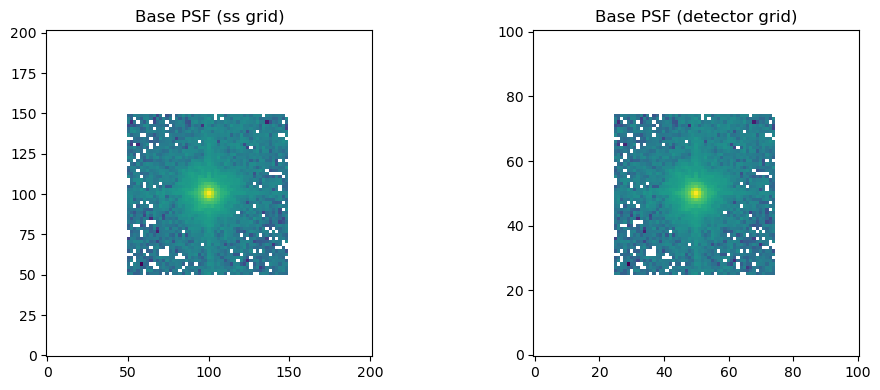

In [4]:
# -----------------------------
# Build base PSF and define render helpers
# -----------------------------
def center_crop_or_pad_np(arr, target_shape):
    ty, tx = target_shape
    ay, ax = arr.shape

    # crop if larger
    if ay > ty:
        y0 = (ay - ty) // 2
        arr = arr[y0:y0 + ty, :]
    if ax > tx:
        x0 = (ax - tx) // 2
        arr = arr[:, x0:x0 + tx]

    # pad if smaller
    ay, ax = arr.shape
    if ay < ty or ax < tx:
        py0 = (ty - ay) // 2
        py1 = ty - ay - py0
        px0 = (tx - ax) // 2
        px1 = tx - ax - px0
        arr = np.pad(arr, ((py0, py1), (px0, px1)), mode="constant", constant_values=0.0)
    return arr


def normalize_np(kernel, eps=1e-20):
    k = np.nan_to_num(kernel, nan=0.0, posinf=0.0, neginf=0.0)
    k = np.clip(k, 0.0, np.inf)
    s = np.sum(k)
    if s <= eps:
        raise ValueError("Kernel normalization failed: sum<=0")
    return k / s


def downsample_mean_np(kernel_ss, factor=2):
    ny_ss, nx_ss = kernel_ss.shape
    return kernel_ss.reshape(ny_ss // factor, factor, nx_ss // factor, factor).mean(axis=(1, 3))


# strict: must exist
if not os.path.exists(BASE_PSF_PATH):
    raise FileNotFoundError(f"Required base PSF not found: {BASE_PSF_PATH}")

with fits.open(BASE_PSF_PATH, memmap=True) as hdul:
    if BASE_PSF_EXT in hdul:
        base_psf_ss_np = np.array(hdul[BASE_PSF_EXT].data, dtype=np.float64)
    else:
        base_psf_ss_np = np.array(hdul[0].data, dtype=np.float64)

print("Loaded external base PSF:", BASE_PSF_PATH)

if base_psf_ss_np.ndim != 2 or base_psf_ss_np.shape[0] != base_psf_ss_np.shape[1]:
    raise ValueError(f"Base PSF must be square 2D, got {base_psf_ss_np.shape}")

# make supersampled shape divisible by SS_FACTOR
ny_ss, nx_ss = base_psf_ss_np.shape
ny_trim = ny_ss - (ny_ss % SS_FACTOR)
nx_trim = nx_ss - (nx_ss % SS_FACTOR)
if ny_trim != ny_ss or nx_trim != nx_ss:
    y0 = (ny_ss - ny_trim) // 2
    x0 = (nx_ss - nx_trim) // 2
    base_psf_ss_np = base_psf_ss_np[y0:y0 + ny_trim, x0:x0 + nx_trim]
    print(f"Trimmed base SS PSF to {base_psf_ss_np.shape} for SS_FACTOR={SS_FACTOR}")

base_psf_ss_np = normalize_np(base_psf_ss_np)
base_det_np = downsample_mean_np(base_psf_ss_np, factor=SS_FACTOR)
base_det_np = normalize_np(base_det_np)

# force detector PSF size to match cutout size
base_det_np = center_crop_or_pad_np(base_det_np, (ny, nx))
base_det_np = normalize_np(base_det_np)

# rebuild supersampled base from detector base to guarantee exact shape compatibility
base_psf_ss_np = np.repeat(np.repeat(base_det_np, SS_FACTOR, axis=0), SS_FACTOR, axis=1)
base_psf_ss_np = normalize_np(base_psf_ss_np)


def normalize_kernel(kernel):
    kernel = jnp.nan_to_num(kernel, nan=0.0, posinf=0.0, neginf=0.0)
    kernel = jnp.clip(kernel, 0.0, jnp.inf)
    total = jnp.sum(kernel)
    return jnp.where(total > 0.0, kernel / total, kernel)


def downsample_mean(kernel_ss, factor=2):
    ny_ss, nx_ss = kernel_ss.shape
    return kernel_ss.reshape(ny_ss // factor, factor, nx_ss // factor, factor).mean(axis=(1, 3))


point_source_model = PointSourceModel(["IMAGE_POSITIONS"])


def render_point_sources_from_kernel(kernel_det, theta_x, theta_y, amplitude):
    theta_x = jnp.atleast_1d(theta_x)
    theta_y = jnp.atleast_1d(theta_y)
    amplitude = jnp.atleast_1d(amplitude)

    x_pix, y_pix = pixel_grid.map_coord2pix(theta_x, theta_y)
    kernel_t = kernel_det.T

    nx_det, ny_det = pixel_grid.num_pixel_axes
    xrange = jnp.arange(nx_det) + kernel_t.shape[0] // 2
    yrange = jnp.arange(ny_det) + kernel_t.shape[1] // 2

    result = jnp.zeros((nx_det, ny_det), dtype=kernel_det.dtype)
    for x0, y0, amp in zip(x_pix, y_pix, amplitude):
        xy_grid = jnp.meshgrid(xrange - x0, yrange - y0)
        result = result + amp * map_coordinates(kernel_t, xy_grid, order=1, mode="nearest")
    return result


def render_single_star(kernel_det, x_pos, y_pos, flux, background):
    kwargs_point_source = [{"ra": x_pos, "dec": y_pos, "amp": flux}]
    theta_x_list, theta_y_list, amp_list = point_source_model.get_multiple_images(
        kwargs_point_source,
        kwargs_lens=None,
        kwargs_solver=None,
        k=0,
        with_amplitude=True,
        zero_amp_duplicates=False,
    )
    image = render_point_sources_from_kernel(kernel_det, theta_x_list[0], theta_y_list[0], amp_list[0])
    return image + background


base_psf_ss = normalize_kernel(jnp.array(base_psf_ss_np, dtype=jnp.float64))
base_psf_det = normalize_kernel(downsample_mean(base_psf_ss, factor=SS_FACTOR))
k_grid_ss = K_grid(base_psf_ss.shape)
k_values_ss = jnp.array(k_grid_ss.k, dtype=jnp.float64)

print("base ss shape:", base_psf_ss.shape)
print("base det shape:", base_psf_det.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(np.array(base_psf_ss), origin="lower", norm="log")
axes[0].set_title("Base PSF (ss grid)")
axes[1].imshow(np.array(base_psf_det), origin="lower", norm="log")
axes[1].set_title("Base PSF (detector grid)")
plt.tight_layout()


In [5]:
# -----------------------------
# Model: STPSF + (Matern + WN Fourier correction) + resize + per-star nuisance
# Flux is solved analytically per star (weighted least squares), not sampled.
# Correction field is projected to have zero 0th/1st moments (no total-flux or centroid drift).
# Mask support: mask_data=1 uses pixel, 0 excludes pixel from fit/likelihood.
# -----------------------------
def weighted_ls_flux(unit_model_stack, data_minus_bkg, err_stack, mask_data, eps=1e-12):
    inv_var = mask_data / (err_stack**2 + eps)
    numer = jnp.sum(unit_model_stack * data_minus_bkg * inv_var, axis=(1, 2))
    denom = jnp.sum((unit_model_stack**2) * inv_var, axis=(1, 2)) + eps
    flux = numer / denom
    return jnp.clip(flux, eps, jnp.inf)


def project_zero_moments(corr, eps=1e-12):
    ny, nx = corr.shape
    yy, xx = jnp.indices((ny, nx), dtype=corr.dtype)
    xx = xx - (nx - 1) / 2.0
    yy = yy - (ny - 1) / 2.0

    b0 = jnp.ones_like(corr)
    bx = xx
    by = yy

    d = corr.reshape(-1)
    B = jnp.stack([b0.reshape(-1), bx.reshape(-1), by.reshape(-1)], axis=1)

    BtB = B.T @ B
    Btd = B.T @ d
    coeff = jnp.linalg.solve(BtB + eps * jnp.eye(3, dtype=corr.dtype), Btd)
    d_proj = d - B @ coeff
    return d_proj.reshape(ny, nx)


def model_psf_svi(sci_data, err_data, mask_data, flux_loc, bkg_loc, bkg_scale, base_psf_ss, k_values):
    _ = flux_loc

    corr_dict = matern_power_spectrum(
        "PSF correction",
        "psf_corr",
        k_values,
        n_value=None,
        positive=False,
    )
    corr_ss_raw = corr_dict["pixels"]
    corr_ss = project_zero_moments(corr_ss_raw)
    numpyro.deterministic("pixels_psf_corr_proj", corr_ss)

    psf_ss_raw = base_psf_ss + corr_ss
    psf_ss_pos = jax.nn.softplus(100.0 * psf_ss_raw) / 100.0
    psf_ss_model = psf_ss_pos / jnp.sum(psf_ss_pos)
    numpyro.deterministic("psf_ss_model", psf_ss_model)

    psf_det_model = downsample_mean(psf_ss_model, factor=SS_FACTOR)
    psf_det_model = psf_det_model / jnp.sum(psf_det_model)
    numpyro.deterministic("psf_det_model", psf_det_model)

    base_det = downsample_mean(base_psf_ss, factor=SS_FACTOR)
    base_det = base_det / jnp.sum(base_det)
    numpyro.deterministic("psf_corr_ss_eff", psf_ss_model - base_psf_ss)
    numpyro.deterministic("psf_corr_det_eff", psf_det_model - base_det)

    n_star = sci_data.shape[0]
    with numpyro.plate("stars", n_star):
        x_pos = numpyro.sample(
            "x_pos",
            dist.TruncatedNormal(
                loc=jnp.zeros(n_star),
                scale=XPOS_PRIOR_SIGMA,
                low=XPOS_BOUNDS[0],
                high=XPOS_BOUNDS[1],
            ),
        )
        y_pos = numpyro.sample(
            "y_pos",
            dist.TruncatedNormal(
                loc=jnp.zeros(n_star),
                scale=YPOS_PRIOR_SIGMA,
                low=YPOS_BOUNDS[0],
                high=YPOS_BOUNDS[1],
            ),
        )
        background = numpyro.sample(
            "background",
            dist.Normal(loc=bkg_loc, scale=bkg_scale),
        )

    unit_model_stack = jax.vmap(render_single_star, in_axes=(None, 0, 0, 0, 0))(
        psf_det_model,
        x_pos,
        y_pos,
        jnp.ones_like(x_pos),
        jnp.zeros_like(background),
    )
    data_minus_bkg = sci_data - background[:, None, None]
    flux_opt = weighted_ls_flux(unit_model_stack, data_minus_bkg, err_data, mask_data)
    numpyro.deterministic("flux_opt", flux_opt)
    numpyro.deterministic("log10_flux_opt", jnp.log10(flux_opt))

    model_stack = unit_model_stack * flux_opt[:, None, None] + background[:, None, None]

    # masked Gaussian log-likelihood
    logp = dist.Normal(model_stack, err_data).log_prob(sci_data)
    logp = jnp.where(mask_data > 0.5, logp, 0.0)
    numpyro.factor("obs_masked", jnp.sum(logp))


rng_key = jax.random.PRNGKey(SEED)

init_fun = infer.init_to_median(num_samples=15)
guide = autoguide.AutoDiagonalNormal(model_psf_svi, init_loc_fn=init_fun, init_scale=0.02)

scheduler = split_scheduler(MAX_ITERATIONS, init_value=0.01, transition_steps=TRANSITION_STEPS)
optim = optax.adabelief(learning_rate=scheduler)
loss = infer.TraceMeanField_ELBO()

svi = SVI_vec(model_psf_svi, guide, optim, loss)

svi_results = svi.run(
    rng_key,
    NUM_CHAINS,
    MAX_ITERATIONS,
    sci_stack,
    err_stack,
    mask_stack,
    flux_loc,
    bkg_loc,
    bkg_scale,
    base_psf_ss,
    k_values_ss,
    stable_update=True,
)

losses_np = np.array(jax.device_get(svi_results.losses))
final_losses = losses_np[:, -1]
best_chain = int(np.argmin(final_losses))
print("Final losses:", final_losses)
print("Best chain:", best_chain)

params_best = jax.tree.map(lambda v: v[best_chain], svi_results.params)
median_best = guide.median(params_best)


Final losses: [1058665.73483192]
Best chain: 0


In [6]:
# -----------------------------
# Posterior samples and required posteriors
# -----------------------------
rng_key, sample_key, pred_key = jax.random.split(rng_key, 3)

posterior_latent = guide.sample_posterior(
    sample_key,
    params_best,
    sample_shape=(NUM_POST_SAMPLES,),
)

return_sites = [
    "psf_ss_model",
    "psf_det_model",
    "pixels_psf_corr",
    "pixels_psf_corr_proj",
    "psf_corr_ss_eff",
    "psf_corr_det_eff",
    "n_psf_corr",
    "rho_psf_corr",
    "sigma_psf_corr",
    "x_pos",
    "y_pos",
    "background",
    "flux_opt",
    "log10_flux_opt",
]

predictive = infer.Predictive(
    model_psf_svi,
    posterior_samples=posterior_latent,
    return_sites=return_sites,
)

posterior = predictive(
    pred_key,
    sci_stack,
    err_stack,
    mask_stack,
    flux_loc,
    bkg_loc,
    bkg_scale,
    base_psf_ss,
    k_values_ss,
)

n_post = np.array(jax.device_get(posterior["n_psf_corr"]))[:, 0]
rho_post = np.array(jax.device_get(posterior["rho_psf_corr"]))[:, 0]
sigma_post = np.array(jax.device_get(posterior["sigma_psf_corr"]))[:, 0]

psf_ss_median = np.median(np.array(jax.device_get(posterior["psf_ss_model"])), axis=0)
psf_det_median = np.median(np.array(jax.device_get(posterior["psf_det_model"])), axis=0)
pixcorr_median = np.median(np.array(jax.device_get(posterior["pixels_psf_corr_proj"])), axis=0)

summary = {
    "n_median": float(np.median(n_post)),
    "n_p16": float(np.percentile(n_post, 16)),
    "n_p84": float(np.percentile(n_post, 84)),
    "rho_median": float(np.median(rho_post)),
    "rho_p16": float(np.percentile(rho_post, 16)),
    "rho_p84": float(np.percentile(rho_post, 84)),
    "sigma_median": float(np.median(sigma_post)),
    "sigma_p16": float(np.percentile(sigma_post, 16)),
    "sigma_p84": float(np.percentile(sigma_post, 84)),
}

summary


{'n_median': 5.190486464569737,
 'n_p16': 5.132706739913365,
 'n_p84': 5.27494179901971,
 'rho_median': 5.253339581302648,
 'rho_p16': 5.175901443630595,
 'rho_p84': 5.322311404575514,
 'sigma_median': 0.025049564352494592,
 'sigma_p16': 0.024807597941668272,
 'sigma_p84': 0.025354531059264176}

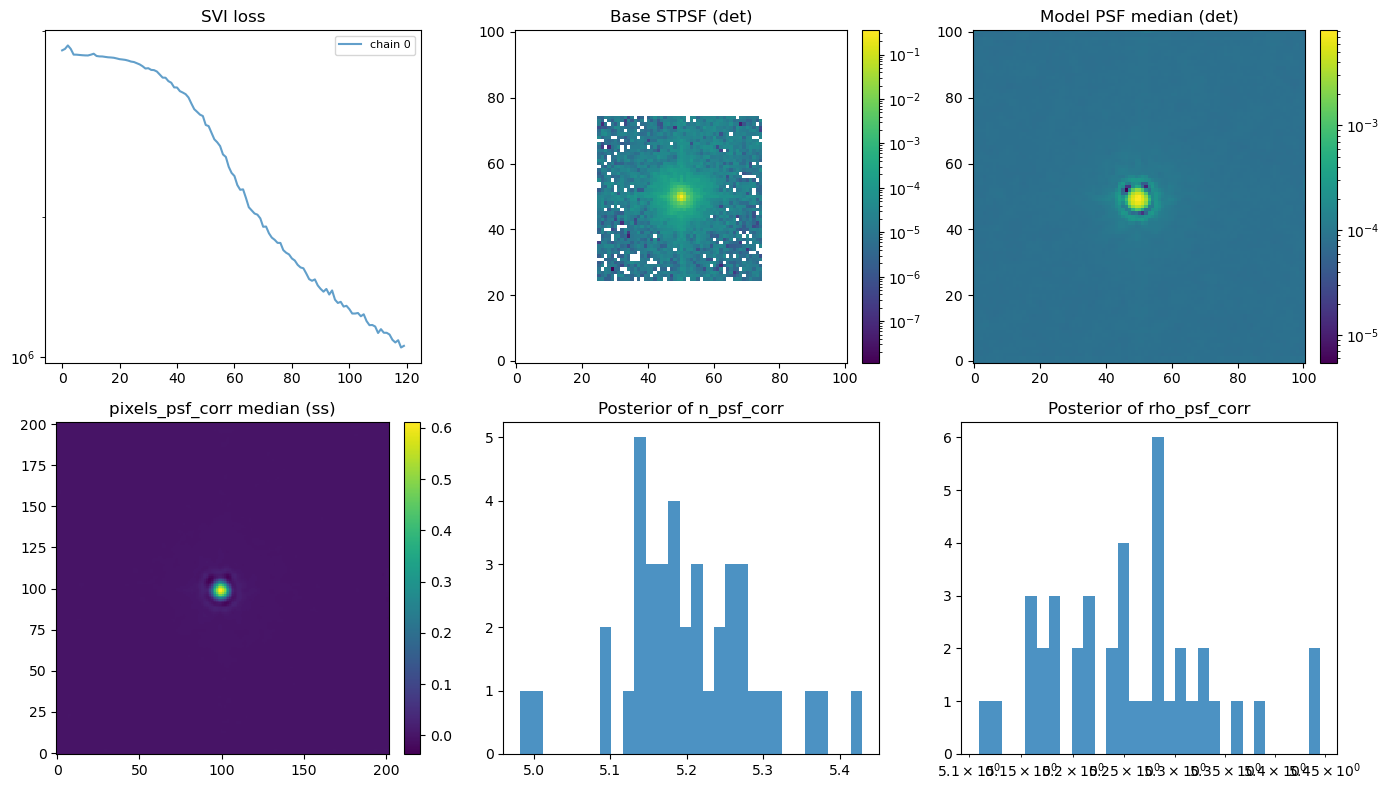

In [7]:
# -----------------------------
# Visual diagnostics
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

for i in range(losses_np.shape[0]):
    axes[0, 0].plot(losses_np[i], alpha=0.7, label=f"chain {i}")
axes[0, 0].set_yscale("asinh")
axes[0, 0].set_title("SVI loss")
axes[0, 0].legend(loc="best", fontsize=8)

im1 = axes[0, 1].imshow(np.array(base_psf_det), origin="lower", norm="log")
axes[0, 1].set_title("Base STPSF (det)")
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

im2 = axes[0, 2].imshow(psf_det_median, origin="lower", norm="log")
axes[0, 2].set_title("Model PSF median (det)")
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)

im3 = axes[1, 0].imshow(pixcorr_median, origin="lower")
axes[1, 0].set_title("pixels_psf_corr median (ss)")
plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

axes[1, 1].hist(n_post, bins=30, alpha=0.8)
axes[1, 1].set_title("Posterior of n_psf_corr")

axes[1, 2].hist(rho_post, bins=30, alpha=0.8)
axes[1, 2].set_xscale("log")
axes[1, 2].set_title("Posterior of rho_psf_corr")

plt.tight_layout()

In [8]:
# -----------------------------
# Save SVI outputs (no HMC)
# -----------------------------
output_fits = os.path.join(OUTPUT_DIR, f"PSF_model_step3_svi{OUTPUT_SUFFIX}.fits")
output_info = os.path.join(OUTPUT_DIR, f"PSF_model_info_step3_svi{OUTPUT_SUFFIX}.npz")

pixels_wn_post = np.array(jax.device_get(posterior_latent["pixels_wn_psf_corr"]))
pixels_wn_median = np.median(pixels_wn_post, axis=0)

corr_proj_median = np.median(np.array(jax.device_get(posterior["pixels_psf_corr_proj"])), axis=0)
corr_eff_ss_median = np.median(np.array(jax.device_get(posterior["psf_corr_ss_eff"])), axis=0)
corr_eff_det_median = np.median(np.array(jax.device_get(posterior["psf_corr_det_eff"])), axis=0)

hdr = fits.Header()
hdr["NSTAR"] = int(n_star)
hdr["PIXSCALE"] = float(PIX_SCALE)
hdr["SSFACT"] = int(SS_FACTOR)
hdr["NPOST"] = int(NUM_POST_SAMPLES)
hdr["NMED"] = float(summary["n_median"])
hdr["RHOMED"] = float(summary["rho_median"])
hdr["SIGMED"] = float(summary["sigma_median"])
hdr["SMOKE"] = (int(SMOKE_TEST), "1 if smoke-test run")

hdul = fits.HDUList([
    fits.PrimaryHDU(header=hdr),
    fits.ImageHDU(data=np.array(psf_ss_median, dtype=np.float32), name="SS_PSF_MODEL"),
    fits.ImageHDU(data=np.array(psf_det_median, dtype=np.float32), name="DET_PSF_MODEL"),
    fits.ImageHDU(data=np.array(corr_proj_median, dtype=np.float32), name="CORR_PROJ_SS"),
    fits.ImageHDU(data=np.array(corr_eff_ss_median, dtype=np.float32), name="CORR_EFF_SS"),
    fits.ImageHDU(data=np.array(corr_eff_det_median, dtype=np.float32), name="CORR_EFF_DET"),
    fits.ImageHDU(data=np.array(pixels_wn_median, dtype=np.float32), name="NOISE_WN_MED"),
    fits.ImageHDU(data=np.array(k_values_ss, dtype=np.float32), name="K_GRID"),
])
hdul.writeto(output_fits, overwrite=True)

np.savez(
    output_info,
    n_post=n_post,
    rho_post=rho_post,
    sigma_post=sigma_post,
    n_median=np.float64(summary["n_median"]),
    rho_median=np.float64(summary["rho_median"]),
    sigma_median=np.float64(summary["sigma_median"]),
    pixels_wn_median=np.array(pixels_wn_median, dtype=np.float32),
    pixels_corr_proj_median=np.array(corr_proj_median, dtype=np.float32),
    psf_det_median=np.array(psf_det_median, dtype=np.float32),
)

print("saved:", output_fits)
print("saved:", output_info)


saved: ./psf_data/PSF_model_step3_svi_smoke.fits
saved: ./psf_data/PSF_model_info_step3_svi_smoke.npz


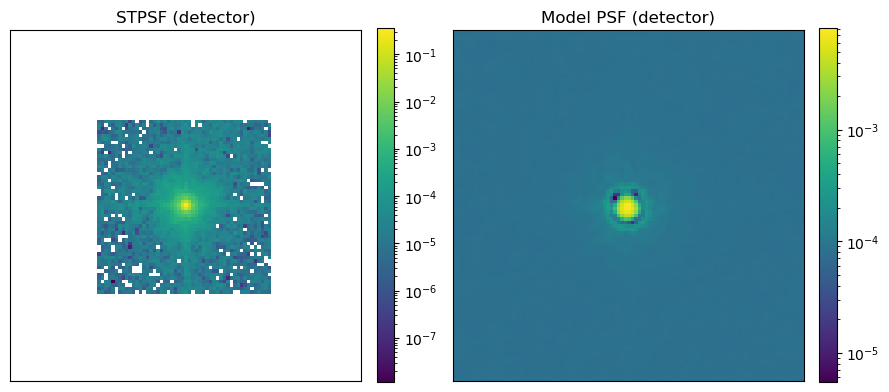

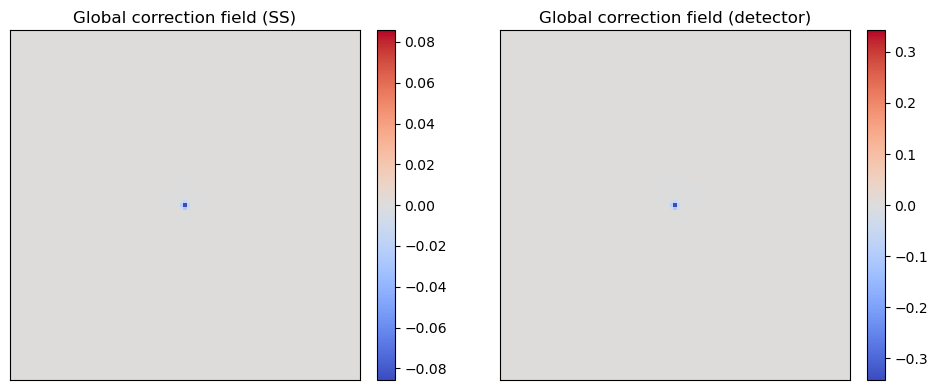

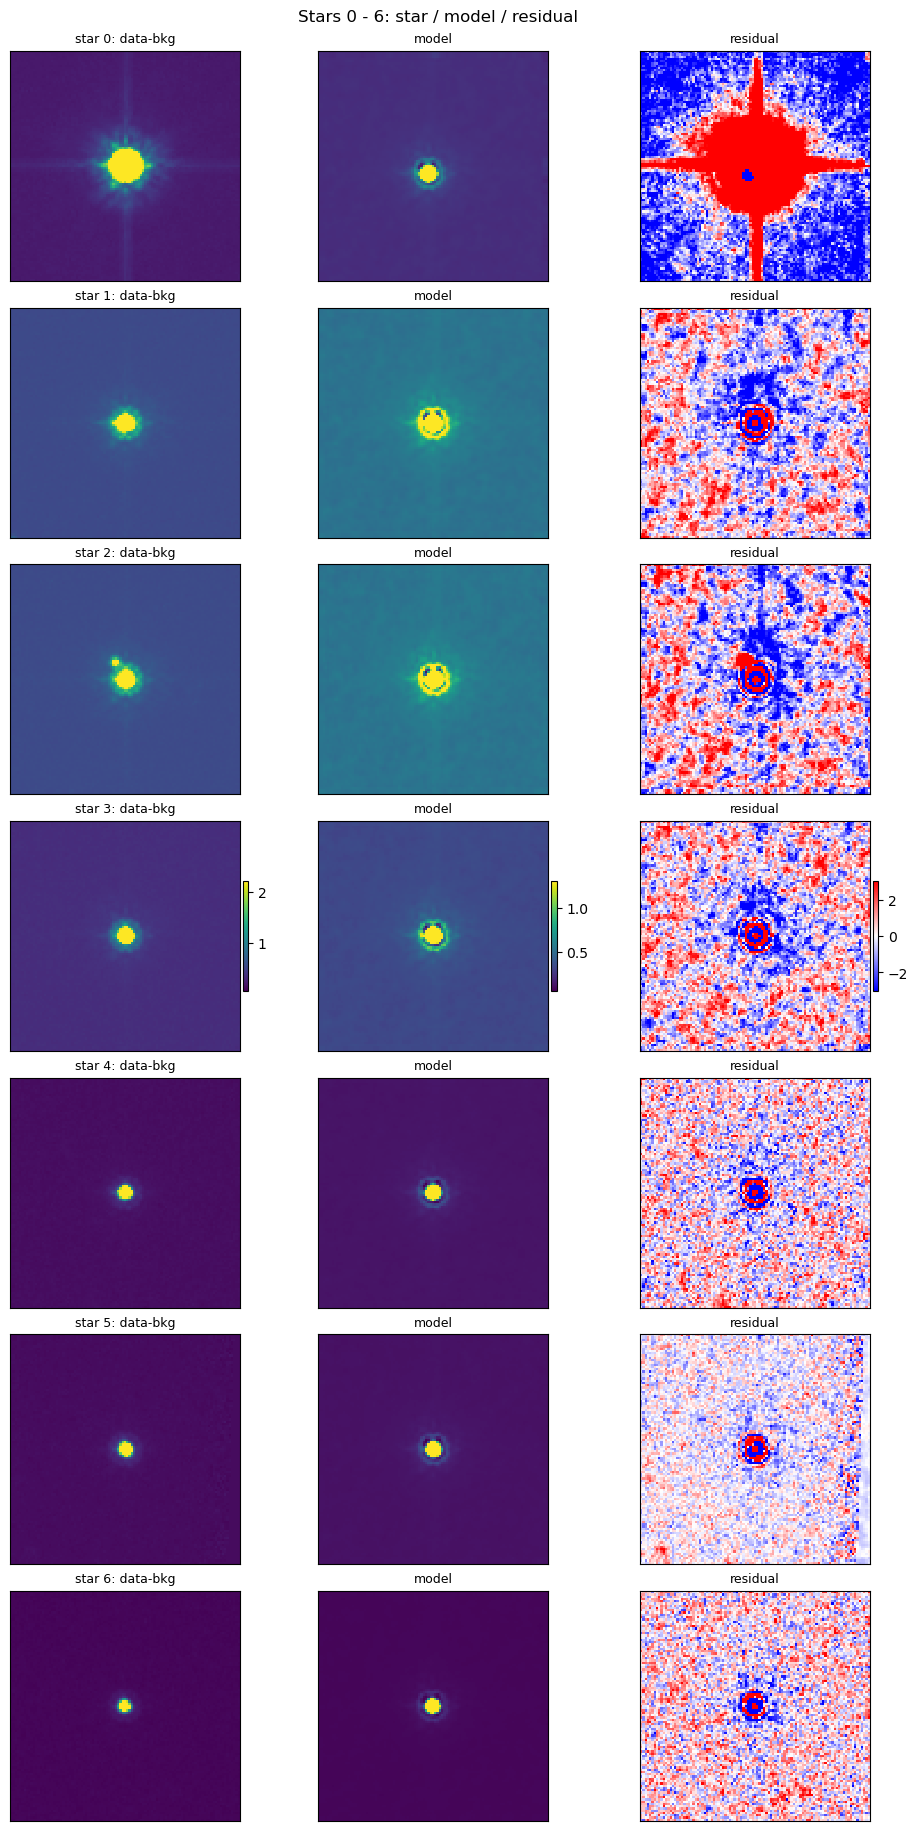

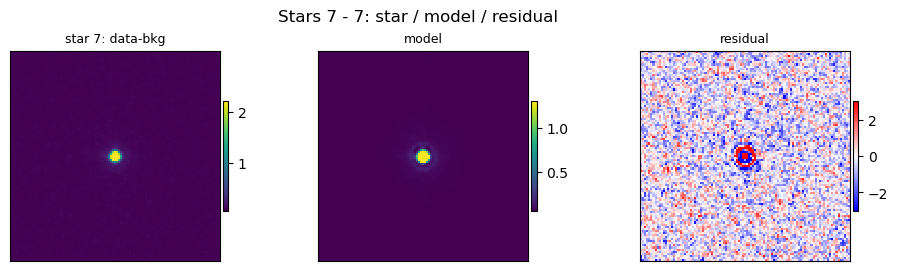

In [9]:
# -----------------------------
# Result display requested:
# - STPSF psf and modeled psf
# - global correction field
# - all stars: star, model, residual
# -----------------------------
x_med = np.median(np.array(jax.device_get(posterior["x_pos"])), axis=0)
y_med = np.median(np.array(jax.device_get(posterior["y_pos"])), axis=0)
flux_med = np.median(np.array(jax.device_get(posterior["flux_opt"])), axis=0)
bkg_med = np.median(np.array(jax.device_get(posterior["background"])), axis=0)


# Model PSF-only image for each star (background fixed to 0)
psf_only_med = jax.vmap(render_single_star, in_axes=(None, 0, 0, 0, 0))(
    jnp.array(psf_det_median),
    jnp.array(x_med),
    jnp.array(y_med),
    jnp.array(flux_med),
    jnp.zeros_like(jnp.array(bkg_med)),
)
psf_only_med = np.array(jax.device_get(psf_only_med))

data_np = np.array(jax.device_get(sci_stack))
err_np = np.array(jax.device_get(err_stack))
bkg_cube = bkg_med[:, None, None]

star_img = data_np - bkg_cube
residual = (data_np - psf_only_med - bkg_cube) / err_np

# (A) STPSF detector PSF and model detector PSF
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
im0 = axes[0].imshow(np.array(base_psf_det), origin="lower", norm="log")
axes[0].set_title("STPSF (detector)")
axes[0].set_xticks([])
axes[0].set_yticks([])
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(np.array(psf_det_median), origin="lower", norm="log")
axes[1].set_title("Model PSF (detector)")
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()

# (B) Global correction field (single field, not per-star)
global_corr_ss = np.array(psf_ss_median) - np.array(base_psf_ss)
global_corr_det = np.array(psf_det_median) - np.array(base_psf_det)

abs_corr_ss = np.max(np.abs(global_corr_ss))
if abs_corr_ss <= 0:
    abs_corr_ss = 1.0
abs_corr_det = np.max(np.abs(global_corr_det))
if abs_corr_det <= 0:
    abs_corr_det = 1.0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im2 = axes[0].imshow(global_corr_ss, origin="lower", cmap="coolwarm", vmin=-abs_corr_ss, vmax=abs_corr_ss)
axes[0].set_title("Global correction field (SS)")
axes[0].set_xticks([])
axes[0].set_yticks([])
plt.colorbar(im2, ax=axes[0], fraction=0.046, pad=0.04)

im3 = axes[1].imshow(global_corr_det, origin="lower", cmap="coolwarm", vmin=-abs_corr_det, vmax=abs_corr_det)
axes[1].set_title("Global correction field (detector)")
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.colorbar(im3, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()

# (C) Show all stars with 3 panels each: star / model / residual
n_show = star_img.shape[0]
chunk_size = 7  # rows per figure

star_vmin, star_vmax = np.percentile(star_img, [1.0, 99.5])
model_vmin, model_vmax = np.percentile(psf_only_med, [1.0, 99.5])

for start in range(0, n_show, chunk_size):
    stop = min(start + chunk_size, n_show)
    nrows = stop - start

    fig, axes = plt.subplots(nrows, 3, figsize=(9.5, 2.6 * nrows), constrained_layout=True)
    axes = np.array(axes)
    if nrows == 1:
        axes = axes[None, :]

    for r, i in enumerate(range(start, stop)):
        im_star = axes[r, 0].imshow(star_img[i], origin="lower", cmap="viridis", vmin=star_vmin, vmax=star_vmax)
        axes[r, 0].set_title(f"star {i}: data-bkg", fontsize=9)

        im_model = axes[r, 1].imshow(psf_only_med[i], origin="lower", cmap="viridis", vmin=model_vmin, vmax=model_vmax)
        axes[r, 1].set_title("model", fontsize=9)

        im_res = axes[r, 2].imshow(residual[i], origin="lower", cmap="bwr", vmin=-3, vmax=3)
        axes[r, 2].set_title("residual", fontsize=9)

        for c in range(3):
            axes[r, c].set_xticks([])
            axes[r, c].set_yticks([])

    fig.colorbar(im_star, ax=axes[:, 0].tolist(), fraction=0.02, pad=0.01)
    fig.colorbar(im_model, ax=axes[:, 1].tolist(), fraction=0.02, pad=0.01)
    fig.colorbar(im_res, ax=axes[:, 2].tolist(), fraction=0.02, pad=0.01)

    fig.suptitle(f"Stars {start} - {stop-1}: star / model / residual", fontsize=12)